# Exploratory notebook
The analysis is based on the Gonzalo-Moser EC paper. 
* 1/28/24 setup
* TODO need to separate the awake and sleep epochs

In [23]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fftpack import fft
from scipy.stats import zscore

sys.path.append("/home/gergely/code/sleep/src")

from suite2p_class import Suite2p

from imaging_data_class import ImagingData
import dfof

s2p_calc_dfof = dfof.Suite2pDFOF(window=1800)
jia_calc_dfof = dfof.JiaDFOF(slow_trend_window=1800)

In [ ]:
mice = ["5HT2afl05b_1", "5HT2afl05b_2", "sert52b_1", "sert52b_5", "sert54a_5"]

In [6]:
mouse = ImagingData(mice[0])
mouse.mouse_id
s2p_folders = mouse.find_suite2p_folders()
for folder in enumerate(s2p_folders):
    print(folder)

Searching for suite2p folders in /data2/gergely/invivo_DATA/sleep/5HT2afl05b_1
(0, '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_Zstack_pento/TSeries-07072021-0833_MC_pento-002/TSeries-07072021-0833_MC_pento-002_Cycle00001_Element00001.sima/s2p/suite2p')
(1, '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_Zstack_pento/TSeries-07072021-0833_GC_pento-001/TSeries-07072021-0833_GC_pento-001_Cycle00001_Element00001.sima/s2p/suite2p')
(2, '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_2/TSeries-07022021-0814_MC-002/TSeries-07022021-0814_MC-002_Cycle00001_Element00001.sima/suite2p')
(3, '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_2/TSeries-07022021-0814-001/TSeries-07022021-0814-001_Cycle00001_Element00001.sima/suite2p')
(4, '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_1/TSeries-07012021-0854_MCs_afternoon-002/TSeries-07012021-0854_MCs_afternoon-002_Cycle00001_Element00001.sima/suite2p')
(5, '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_1/TSeries-07012021-0854_MCs-001/TS

In [10]:
s2p_folder = s2p_folders[9]

In [13]:
s2p_data = Suite2p(s2p_folder=s2p_folder)
cells = s2p_data.get_cells()
npil = s2p_data.get_npil()

In [14]:
cell_dfof = s2p_calc_dfof.calculate(signal=cells, npil=npil)

## Calcluates and plots the autocorrelation of the traces. 

In [ ]:
autocorrelations = []
# Iterate over each row (each signal trace)
for index, row in cell_dfof.iterrows():
    # Convert the row to a NumPy array
    data = row.values

    # Compute the autocorrelation
    autocorr = np.correlate(data, data, mode="full")
    autocorr /= np.max(autocorr)  # Normalize
    autocorr = autocorr[len(autocorr) // 2 :]  # Take the second half

    # Store the result
    autocorrelations.append(autocorr)

    # Optional: Plot each autocorrelation
    plt.figure()
    plt.plot(autocorr)
    plt.title(f"Autocorrelation of Signal Trace {index+1}")
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.show()

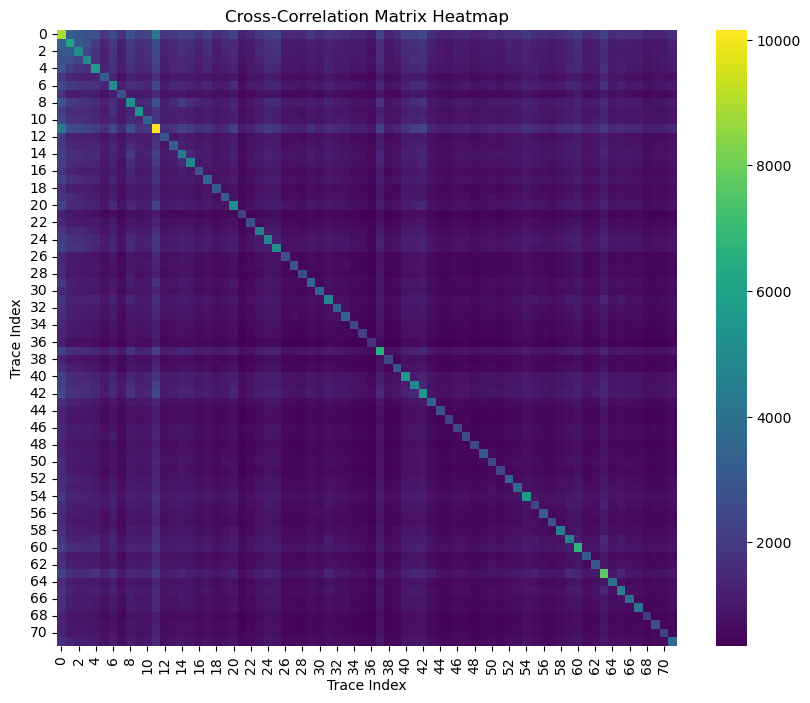

In [21]:
# this runs for 10+ minutes!!!
num_traces = cell_dfof.shape[0]
# Initialize a matrix to store cross-correlation results
cross_corr_matrix = np.zeros((num_traces, num_traces))

# Compute cross-correlation for each pair of traces
for i in range(num_traces):
    for j in range(num_traces):
        # Cross-correlate the i-th and j-th trace
        cross_corr = np.correlate(
            cell_dfof.iloc[i, :], cell_dfof.iloc[j, :], mode="full"
        )
        # You might want to normalize or process the cross-correlation result further
        cross_corr_matrix[i, j] = np.max(cross_corr)  # Example: store the maximum value

# Heatmap Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(cross_corr_matrix, annot=False, cmap="viridis")
plt.title("Cross-Correlation Matrix Heatmap")
plt.xlabel("Trace Index")
plt.ylabel("Trace Index")
plt.show()

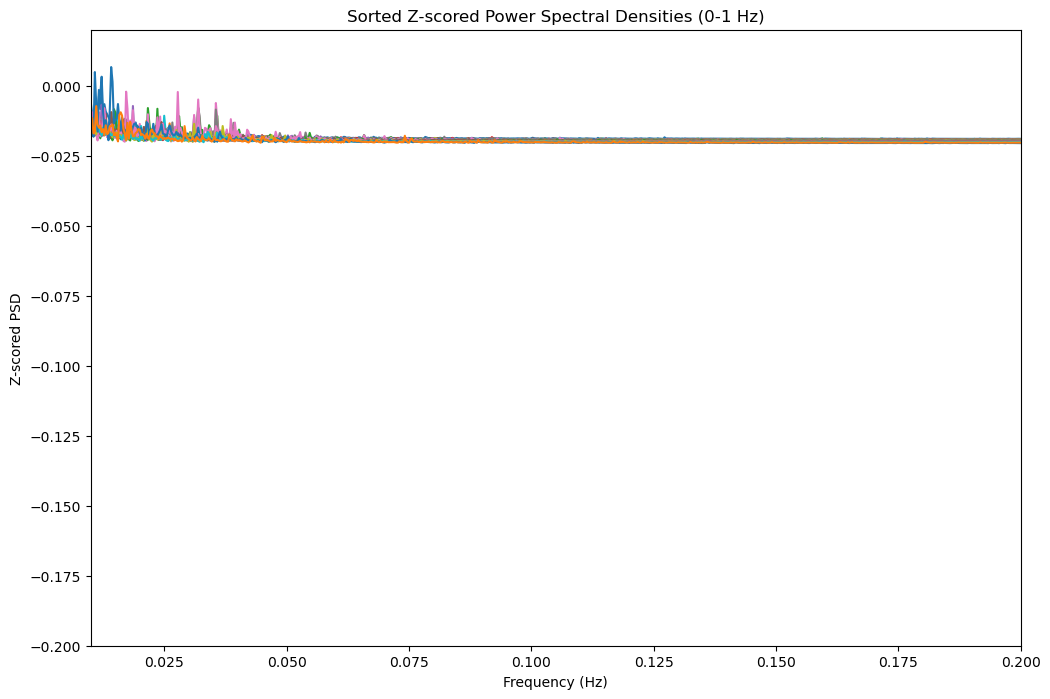

In [36]:
# Your sampling rate
sampling_rate = 10  # Replace with your actual sampling rate

# Length of the autocorrelation data
N = len(autocorrelations[0])

# Calculate the frequency values corresponding to FFT output
frequencies = np.fft.fftfreq(N, d=1 / sampling_rate)

# Indices for frequencies between 0 and 1 Hz
low_freq_indices = np.where((frequencies >= 0) & (frequencies <= 1))[0]

psd_list = []
for autocorr in autocorrelations:
    # Calculate the Fourier Transform
    psd = np.abs(fft(autocorr)) ** 2

    # Select the PSD components for 0-1 Hz
    psd_low_freq = psd[low_freq_indices]

    # Z-score normalization
    psd_z_scored = zscore(psd_low_freq)
    psd_list.append(psd_z_scored)

# Sorting based on the maximum power
psd_sorted = sorted(psd_list, key=lambda x: np.max(x), reverse=True)

# Plotting
plt.figure(figsize=(12, 8))
for psd in psd_sorted:
    plt.plot(
        frequencies[low_freq_indices], psd
    )  # Ensure the x-axis is using the selected frequencies
plt.title("Sorted Z-scored Power Spectral Densities (0-1 Hz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Z-scored PSD")
plt.xlim(0.01, 0.2)  # Set x-axis limit to show only 0 to 1 Hz
plt.ylim(-0.2, 0.02)  # Set y-axis limit to show the PSDs
plt.show()

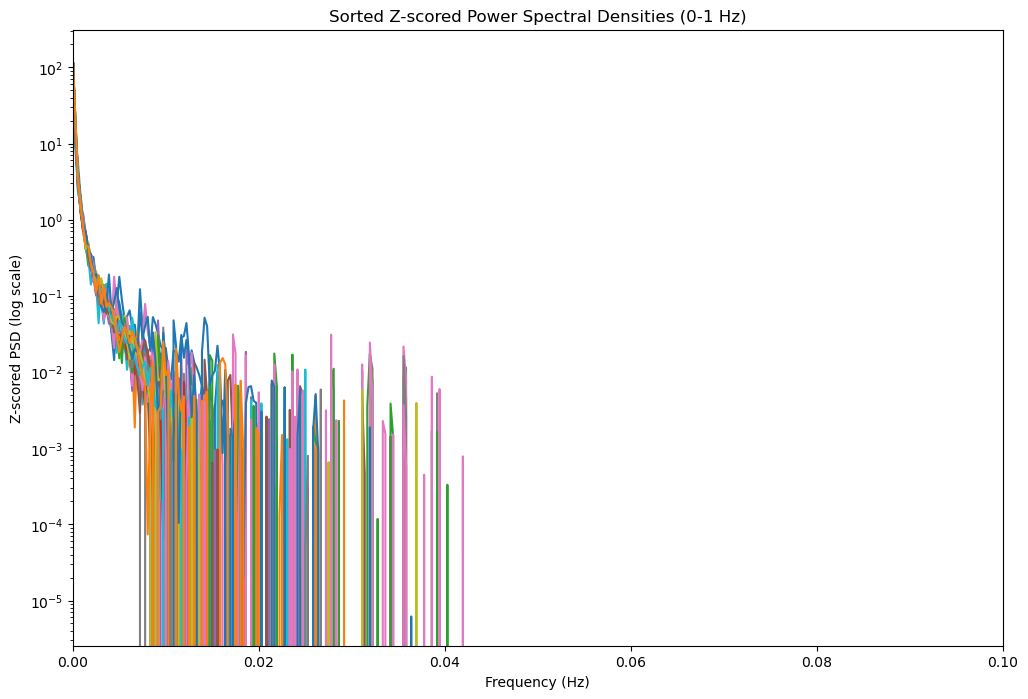

In [39]:
# Your sampling rate
sampling_rate = 10  # Replace with your actual sampling rate

# Length of the autocorrelation data
N = len(autocorrelations[0])

# Calculate the frequency values corresponding to FFT output
frequencies = np.fft.fftfreq(N, d=1 / sampling_rate)

# Indices for frequencies between 0 and 1 Hz
low_freq_indices = np.where((frequencies >= 0) & (frequencies <= 5))[0]

psd_list = []
for autocorr in autocorrelations:
    # Calculate the Fourier Transform
    psd = np.abs(fft(autocorr)) ** 2

    # Select the PSD components for 0-1 Hz
    psd_low_freq = psd[low_freq_indices]

    # Z-score normalization
    psd_z_scored = zscore(psd_low_freq)
    psd_list.append(psd_z_scored)

# Sorting based on the maximum power
psd_sorted = sorted(psd_list, key=lambda x: np.max(x), reverse=True)

# Plotting with semilogy
plt.figure(figsize=(12, 8))
for psd in psd_sorted:
    plt.semilogy(
        frequencies[low_freq_indices], psd
    )  # Use semilogy for logarithmic y-axis
plt.title("Sorted Z-scored Power Spectral Densities (0-1 Hz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Z-scored PSD (log scale)")
plt.xlim(0, 0.1)  # Set x-axis limit to show only 0 to 1 Hz
plt.show()